# General data analysis

Idea: test on jupyternotebok and then create final function to run using a for loop on both dataset

NB: inspired by the events_analysis.py from MRP

## Initialization

In [141]:
import json
import math
import random
import os
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import sys


In [142]:
project_root = os.path.abspath(os.path.join('..'))
if project_root not in sys.path:
    sys.path.append(project_root)

print(project_root)

c:\Users\aurel\Documents\GitHub\Code_Thesis_GitHub\Code_Thesis_GitHub


In [143]:
from event_model import event_model as em
import data_analysis.event_generator as eg
from algorithms import clustering
from algorithms.clustering import Clustering
from validator.validator_lite import MCParticle

In [144]:
def data_distribution(data):
    total = 0
    for num in data:
        total += num

    mu = total / len(data)

    aux = 0
    for num in data:
        aux += ((num - mu) ** 2)

    variance = aux / len(data)
    sigma = math.sqrt(variance)

    print(f'Mean: {mu}')
    print(f'Variance: {variance}')
    print(f'Standard deviation: {sigma}')

    return mu, variance, sigma

In [145]:
def plot_distribution(mu, sigma, title='Distribution', safe_to_file=False):
    x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label='pdf')
    plt.title(title)
    plt.text(-300, .0020, fr'$\mu={round(mu, 4)},\ \sigma={round(sigma, 4)}$')
    # plt.plot(x, stats.norm.cdf(x, mu, sigma), label='cdf')
    plt.legend()
    plt.grid(True)
    if safe_to_file:
        plt.savefig(f'event_plots/{title}', bbox_inches='tight', pad_inches=0.2)
        plt.close()
    else:
        plt.show()


## 1. Number of hits by events (total, pur, noisy)

In [146]:
def get_json_data_from_folder(data_set_folder):
    jsons = []
    # for (dirpath, dirnames, filenames) in os.walk(f"../events/{data_set_folder}"):
    for (dirpath, dirnames, filenames) in os.walk(os.path.join(project_root, f"datasets/{data_set_folder}")):
        filenames = sorted(filenames, key=lambda filename: int(filename.replace('velo_event_', '').replace('.json', '')))
        for i, filename in enumerate(filenames):
            # Get an event
            # print(f'opening: {filename}')
            f = open(os.path.realpath(os.path.join(dirpath, filename)))
            json_data = json.loads(f.read())
            event = em.event(json_data)
            f.close()
            # print(f'closing : {filename}')

            jsons.append(json_data)
    return jsons

In [147]:
jsons = get_json_data_from_folder('minibias')


In [148]:
print(len(jsons))

995


In [149]:
def tracks_from_data(json_data, only_reconstructible=True):
    reconstructible_tracks = []
    hits = []
    counter = 0
    for hid, (x, y, z) in enumerate(zip(json_data["x"], json_data["y"], json_data["z"])):
        hits.append(em.hit(x, y, z, hid))
        
    description = json_data["montecarlo"]["description"]
    particles = json_data["montecarlo"]["particles"]

    for p in particles:
        d = {description[i]: p[i] for i in range(len(description))}
        track_hits = [hits[hit_number] for hit_number in d["hits"]]
        
        if only_reconstructible:
            if len(track_hits) >= 3:
                reconstructible_tracks.append(em.track(track_hits))
        else:
            reconstructible_tracks.append(em.track(track_hits))

    return reconstructible_tracks, hits

In [150]:
reconstructible_tracks_list = []
hits_list = []
nr_hits_list = []
for event in jsons:
    tracks, hits = tracks_from_data(event, True)
    reconstructible_tracks_list.append(tracks)
    hits_list.append(hits)
    nr_hits_list.append(len(hits))


In [151]:
print(nr_hits_list)

[996, 2422, 135, 3172, 2089, 3147, 2938, 890, 767, 3070, 1874, 2987, 1123, 1305, 987, 212, 2069, 1341, 1257, 3911, 647, 179, 523, 1486, 3201, 860, 2020, 663, 1299, 2842, 700, 3011, 1048, 2679, 1102, 362, 737, 820, 519, 484, 2540, 566, 1999, 1335, 4223, 1960, 1312, 1053, 2083, 1425, 1928, 1567, 2054, 1173, 4622, 1532, 3233, 1664, 1620, 1774, 2340, 777, 2388, 3187, 1644, 399, 3387, 2648, 2749, 4008, 340, 1508, 1079, 1199, 593, 1883, 1502, 1388, 4377, 1382, 3670, 371, 463, 318, 2142, 3006, 1767, 2715, 1384, 3367, 1308, 2147, 1490, 2252, 2423, 2319, 755, 3039, 682, 2277, 1028, 2268, 2951, 1823, 1311, 2180, 1581, 1504, 3182, 1594, 1359, 2256, 908, 1450, 2237, 1793, 1120, 1552, 1041, 3215, 1800, 267, 1763, 2430, 2635, 426, 1850, 2049, 4223, 506, 4168, 5797, 1148, 1114, 1216, 1644, 3356, 1271, 1055, 2190, 2094, 1764, 999, 860, 1652, 3305, 1137, 3300, 110, 2067, 2595, 587, 2662, 3013, 2770, 1607, 1907, 1054, 3748, 2308, 3144, 403, 712, 2363, 1912, 3738, 1731, 2028, 2135, 1656, 3355, 1326, 4065

> total number of hits in the event

In [169]:
total = 0
for num in nr_hits_list:
    total += num
    print(total)

mu = total / len(nr_recon_tracks_list)


996
3418
3553
6725
8814
11961
14899
15789
16556
19626
21500
24487
25610
26915
27902
28114
30183
31524
32781
36692
37339
37518
38041
39527
42728
43588
45608
46271
47570
50412
51112
54123
55171
57850
58952
59314
60051
60871
61390
61874
64414
64980
66979
68314
72537
74497
75809
76862
78945
80370
82298
83865
85919
87092
91714
93246
96479
98143
99763
101537
103877
104654
107042
110229
111873
112272
115659
118307
121056
125064
125404
126912
127991
129190
129783
131666
133168
134556
138933
140315
143985
144356
144819
145137
147279
150285
152052
154767
156151
159518
160826
162973
164463
166715
169138
171457
172212
175251
175933
178210
179238
181506
184457
186280
187591
189771
191352
192856
196038
197632
198991
201247
202155
203605
205842
207635
208755
210307
211348
214563
216363
216630
218393
220823
223458
223884
225734
227783
232006
232512
236680
242477
243625
244739
245955
247599
250955
252226
253281
255471
257565
259329
260328
261188
262840
266145
267282
270582
270692
272759
275354
275941
2

In [152]:
mu, var, sigma = data_distribution(nr_hits_list)

Mean: 1963.8763819095477
Variance: 1208248.6389899263
Standard deviation: 1099.2036385447086


In [153]:
def plot_distribution(mu, sigma, title='Distribution', safe_to_file=False):
    x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label='pdf')
    plt.title(title)
    plt.text(-300, .0020, fr'$\mu={round(mu, 4)},\ \sigma={round(sigma, 4)}$')
    #plt.plot(x, stats.norm.cdf(x, mu, sigma), label='cdf')
    plt.legend()
    plt.grid(True)
    if safe_to_file:
        plt.savefig(f'event_plots/{title}', bbox_inches='tight', pad_inches=0.2)
        plt.close()
    else:
        plt.show()

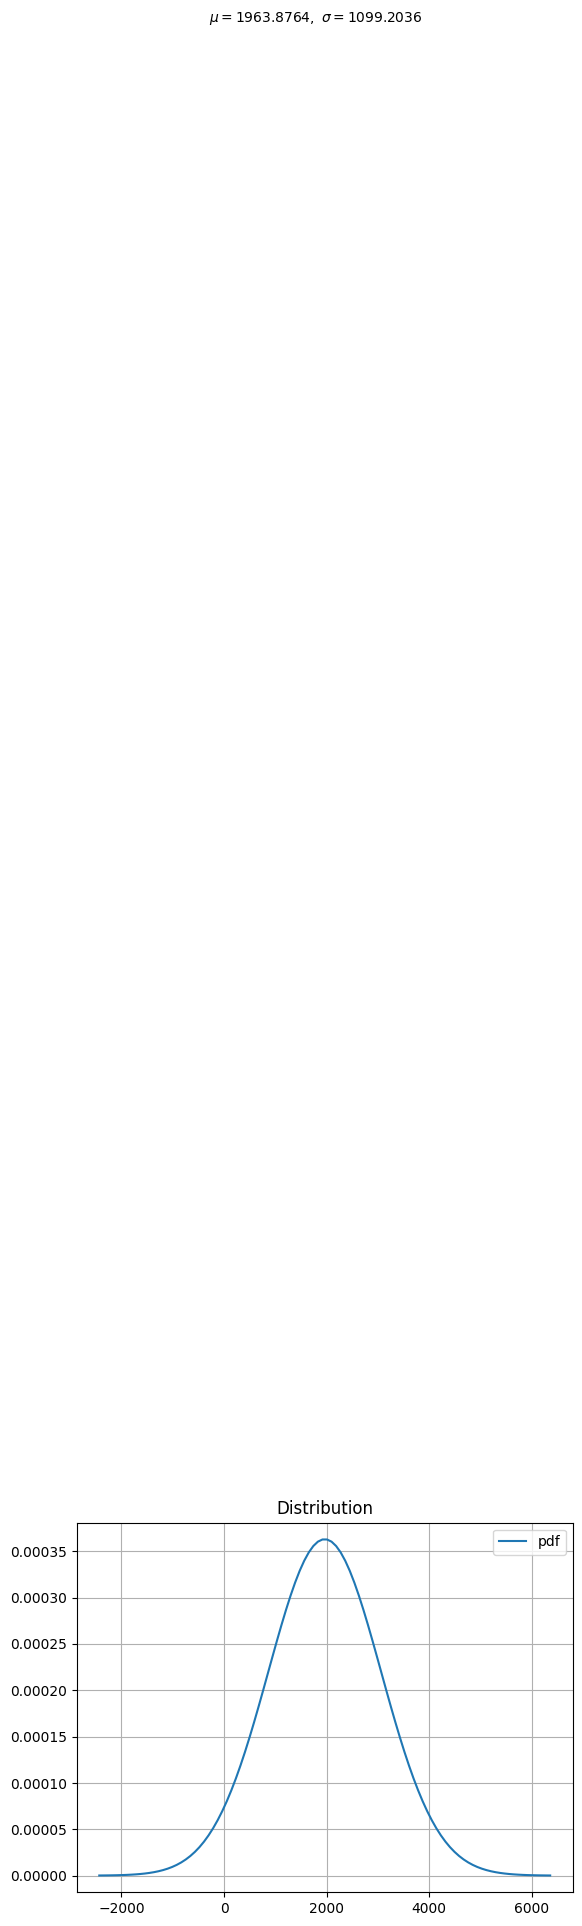

In [154]:
plot_distribution(mu, sigma, title='Distribution', safe_to_file=False)


In [104]:
def noise_from_data(json_data,only_reconstructible=True):
    noise = 0
    hits_in_reconstructible_tracks = 0
    tracks = []
    hits = []
    for hid, (x, y, z) in enumerate(zip(json_data["x"], json_data["y"], json_data["z"])):
        hits.append(em.hit(x, y, z, hid))


    description = json_data["montecarlo"]["description"]
    particles = json_data["montecarlo"]["particles"]

    for p in particles:
        d = {description[i]: p[i] for i in range(len(description))}
        track_hits = [hits[hit_number] for hit_number in d["hits"]]

        if only_reconstructible:
            if len(track_hits) >= 3:
                hits_in_reconstructible_tracks += len(track_hits)
        else:
            hits_in_reconstructible_tracks += len(track_hits)

    noise = len(hits) - hits_in_reconstructible_tracks
    return noise

In [116]:
nr_noise_list = []
for event in jsons:
    noise = noise_from_data(event,True)
    nr_noise_list.append(noise)

In [117]:
print(len(nr_noise_list))
print((nr_noise_list[2]))

995
5


> number of noise hits in the event

In [139]:
mu, var, sigma =data_distribution(nr_noise_list)

Mean: 214.01507537688443
Variance: 15246.028918461674
Standard deviation: 123.47481086627214


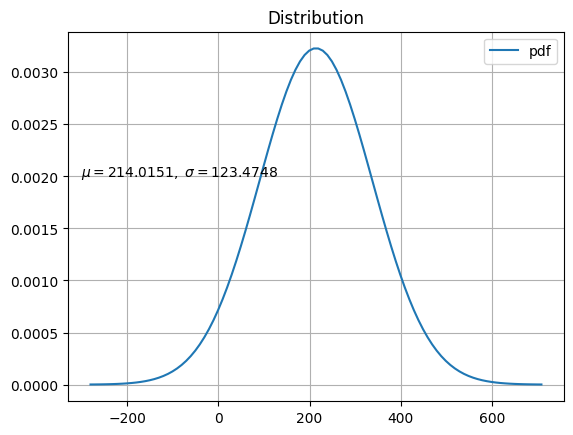

In [140]:
plot_distribution(mu, sigma, title='Distribution', safe_to_file=False)

In [122]:
total_hits = sum(nr_hits_list)
total_noise = sum(nr_noise_list)
percentage= total_noise/total_hits
print(percentage)

0.10897583847349386


## 2. Number of tracks by event

In [156]:
reconstructible_tracks_list = []
nr_recon_tracks_list = []

for event in jsons:
    tracks, hits = tracks_from_data(event, True)
    reconstructible_tracks_list.append(tracks)
    hits_list.append(hits)
    nr_recon_tracks_list.append(len(tracks))

In [158]:
print(len(nr_recon_tracks_list))
print(nr_recon_tracks_list)

995
[153, 343, 13, 463, 305, 431, 397, 134, 94, 436, 271, 373, 169, 179, 152, 28, 283, 181, 170, 564, 104, 23, 83, 226, 450, 130, 280, 96, 161, 407, 96, 406, 145, 351, 148, 47, 104, 109, 72, 73, 376, 87, 274, 183, 589, 288, 189, 157, 315, 192, 238, 193, 298, 156, 628, 220, 434, 222, 211, 240, 315, 112, 341, 445, 230, 57, 502, 399, 387, 524, 56, 210, 169, 178, 75, 265, 220, 192, 652, 212, 553, 52, 60, 37, 308, 408, 237, 398, 173, 484, 159, 306, 218, 325, 347, 305, 107, 429, 91, 300, 119, 337, 404, 251, 183, 283, 207, 216, 452, 194, 196, 329, 148, 195, 339, 258, 148, 196, 153, 453, 276, 40, 229, 330, 364, 70, 279, 259, 624, 74, 602, 807, 169, 156, 173, 248, 474, 153, 148, 275, 293, 229, 126, 117, 224, 451, 161, 453, 20, 278, 384, 80, 381, 400, 385, 230, 253, 125, 484, 274, 444, 64, 95, 337, 276, 530, 250, 289, 313, 232, 478, 177, 574, 520, 264, 421, 336, 106, 362, 68, 164, 209, 497, 125, 288, 302, 387, 213, 673, 402, 156, 45, 123, 99, 87, 246, 144, 46, 349, 353, 404, 66, 388, 202, 702, 3

In [159]:
mu, var, sigma = data_distribution(nr_recon_tracks_list)

Mean: 274.2733668341709
Variance: 23791.503160021166
Standard deviation: 154.24494533053965


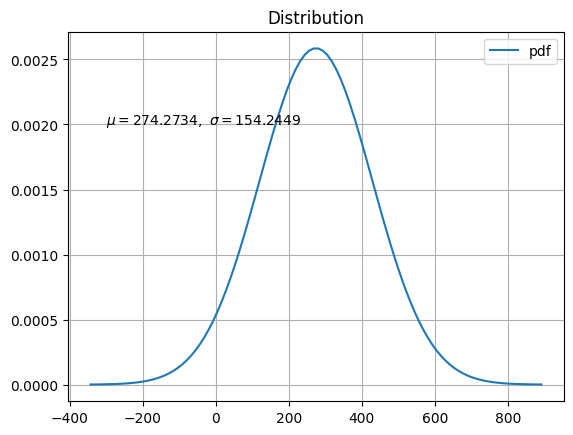

In [160]:
plot_distribution(mu, sigma, title='Distribution', safe_to_file=False)

## 3. Number of hits by tracks (total = length, normal and noisy hits distribution)

## 4. Histogram with distribution of total number of hits by module + noise hits by module (MRP txt + histogram somewhere in the code)